## change the model here

In [ ]:
model_name = "o1-2024-12-17"
model_provider = "openai"

### anywhere below, the most problematic part is reconsider_with_monocle prompting and output
### so if you meet any error in running, just re-run everything

In [2]:
import numpy
from py_monocle import (
    learn_graph,
    order_cells,
    compute_cell_states,
    regression_analysis,
    differential_expression_genes,
)
import os
import h5py
import scanpy as sc
from scipy import sparse

In [3]:
import numpy as np
# Load data and reconstruct objects
with h5py.File("uploads/traj2_processed.h5", "r") as f:
    umap = f["UMAP"][()]
    louvain = f["Louvain"][()]
    barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
    features = [ft.decode() for ft in f["expression_matrix/features"]]
    data = f["expression_matrix/data"][()]
    indices = f["expression_matrix/indices"][()]
    indptr = f["expression_matrix/indptr"][()]
    timepoints = np.array([tp.decode() for tp in f["timepoint"]])
# Reconstruct expression matrix
expression_matrix = sparse.csr_matrix(
    (data, indices, indptr),
    shape=(len(barcodes), len(features))
)
# Infer trajectory
projected_points, mst, centroids = learn_graph(matrix=umap, clusters=louvain)

In [4]:
# Define root cells using earliest timepoint (e.g., "E7.5")
unique_timepoints = ['E7.5', 'E8.5', 'E9.5', 'E10.5']  # e.g., 
earliest = unique_timepoints[0]
root_cells = np.where(timepoints == earliest)[0]
pseudotime = order_cells(
    umap, centroids,
    mst=mst,
    projected_points=projected_points,
    root_cells=root_cells,
)

In [5]:
adata = sc.read_h5ad("uploads/traj2_final.h5ad")

1. On the cluster level, interpret which branch corresponds to which cell. This is more like a regular cell type annotation.

In [6]:
import json
with open("uploads/traj2_top5_dict.json", "r") as f:
    top5_dict = json.load(f)

In [7]:
percentage_df = (adata.obs.groupby("leiden")["timepoint"].value_counts(normalize=True).mul(100).unstack(fill_value=0).sort_index())
day_percentage = percentage_df.reset_index().to_dict(orient="records")
print(day_percentage)

[{'leiden': 0, 'E10.5': 11.284046692607005, 'E7.5': 0.0, 'E8.5': 63.61867704280155, 'E9.5': 25.09727626459144}, {'leiden': 1, 'E10.5': 0.0, 'E7.5': 97.8891820580475, 'E8.5': 2.1108179419525066, 'E9.5': 0.0}, {'leiden': 2, 'E10.5': 56.91943127962086, 'E7.5': 2.085308056872038, 'E8.5': 36.161137440758296, 'E9.5': 4.834123222748815}, {'leiden': 3, 'E10.5': 7.725705529306602, 'E7.5': 5.605925169199336, 'E8.5': 85.21261652407101, 'E9.5': 1.455752777423062}, {'leiden': 4, 'E10.5': 0.47318611987381703, 'E7.5': 88.17034700315457, 'E8.5': 11.198738170347003, 'E9.5': 0.15772870662460567}, {'leiden': 5, 'E10.5': 42.990904226859286, 'E7.5': 26.190476190476193, 'E8.5': 2.5949705724986623, 'E9.5': 28.223649010165865}, {'leiden': 6, 'E10.5': 98.4331797235023, 'E7.5': 0.0, 'E8.5': 0.0, 'E9.5': 1.566820276497696}, {'leiden': 7, 'E10.5': 0.15339562125226608, 'E7.5': 70.8827220750244, 'E8.5': 28.76865151303863, 'E9.5': 0.19523079068470228}, {'leiden': 8, 'E10.5': 4.421768707482993, 'E7.5': 0.0, 'E8.5': 1

/var/folders/9w/5ntdw9rd1h11b_tfvc7yq4t80000gn/T/ipykernel_25492/254422332.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = (adata.obs.groupby("leiden")["timepoint"].value_counts(normalize=True).mul(100).unstack(fill_value=0).sort_index())


In [8]:
context = '''
    You should understand that, this dataset is a developmental liver dataset in embryo, the time points are E7.5, 8.5, 9.5 and 10.5. We need to find the development of each celltype. They should be in developing different stages from endoderm to hepatoblasts.
'''

In [9]:
from utils.LLM import query_llm
def annotate_clusters(context,top5_dict,day_percentage,model_name,model_provider):
    query = f"""
    You are analyzing single-cell RNA-seq data. The dataset contains clusters of cells identified by Leiden clustering.
    Given these clusters and reference cell types, predict the most likely annotation for each cluster. 
    First, read the context. Then, use the top 5 genes to annotate each cluster. Finally, refine the annotation with the percentage of timepoint in each cluster, so you will know the cell type in the cluster is more likely in the proliferating or mature stage.

    Please refer to the context information of the dataset:
    {context}
    Please base your annotation on the top 5 genes of each cluster:
    {top5_dict}
    Here is the percentage of timepoint in each cluster: 
    {day_percentage}

    Remember, every cluster is a distinct cell type.
    
    Provide output as a dictionary mapping cluster IDs to cell type annotations.
    ONLY output python code dictionary please, do not include ```python ```.
    """
    response = query_llm(content=query, system_role="Bioinformatics LLM",model_name=model_name,model_provider=model_provider)
    return eval(response)  

annotated_clusters = annotate_clusters(context=context, top5_dict=top5_dict,day_percentage=day_percentage,model_name=model_name,model_provider=model_provider)
#annotated_clusters = mapping_dict
print(annotated_clusters)
adata.obs['llm_annotated'] = adata.obs['leiden'].map(annotated_clusters)

{'0': 'Cardiomyocytes', '1': 'Endodermal progenitors', '2': 'Endothelial cells', '3': 'Epithelial progenitors', '4': 'Hematopoietic progenitors', '5': 'Hepatic progenitors', '6': 'Hepatoblasts', '7': 'Proliferating endodermal cells', '8': 'Mature hepatocytes', '9': 'Embryonic stem cells', '10': 'Undifferentiated stem cells', '11': 'Mature endothelial cells', '12': 'Mature hepatoblasts', '13': 'Primitive streak mesoderm', '14': 'Proliferating hepatocytes'}


2. Connect the stages into trajectories, that elaborate which cell type developed at which given time stage. 

In [10]:
adata.obs['llm_annotated'] = adata.obs['llm_annotated'].astype("category")
adata.obs['timepoint'] = adata.obs['timepoint'].astype("category")

import json,ast,re
def build_trajectory_tree(annotated_clusters,context,day_percentage,model_name,model_provider):
    query = f"""
    Construct a developmental trajectory tree for the clusters in the single-cell dataset. 
    Here is the context: {context}
    Ensure:
    1. The tree starts from the root (youngest stage).
    2. Progression follows biologically meaningful paths.
    3. Misplaced branches are flagged.

    Data:
    4. Cell Type annotation for each cluster: {annotated_clusters}
    5. Developmental stages: {day_percentage}

    In your trajectory tree, do not include any time stage, only use the Cell clusters.
    We need to set a dummy node as root (use the name "root"), and then add all cell types iteratively as leaves and leaves of leaves. DO NOT include any other node except root and cell types.

    IN YOUR REPLY, ONLY output python code tree, DO NOT include ```python ```. You can represent a tree using nested dict
    """
    response = query_llm(content=query, system_role="Bioinformatics LLM",model_name=model_name,model_provider=model_provider)

    try:
        return json.loads(response)
    except json.JSONDecodeError:
        pass
    # --- otherwise clean code-fence & literal_eval -----------------------
    cleaned = re.sub(r'^```[\w+-]*\n|\n```$', '', response.strip(), flags=re.S)
    try:
        return ast.literal_eval(cleaned)
    except (ValueError, SyntaxError) as e:
        raise ValueError(f"Could not parse trajectory_tree: {e}\n\nRaw text:\n{response}")

In [11]:
from utils.traj_util import validate_trajectory_tree
while True:
    try:
        trajectory_tree = build_trajectory_tree(annotated_clusters=annotated_clusters,context=context,day_percentage=day_percentage,model_name=model_name,model_provider=model_provider)
        if validate_trajectory_tree(trajectory_tree):
            break         
    except Exception as err:
        print(f"Invalid tree, will retry → {err}")
        continue
print("valid tree\n")
print(trajectory_tree)

valid tree

{'root': {'Endodermal progenitors': {'Proliferating endodermal cells': {'Epithelial progenitors': {'Hepatic progenitors': {'Hepatoblasts': {'Mature hepatoblasts': {'Mature hepatocytes': {}}}, 'Proliferating hepatocytes': {}}, 'Primitive streak mesoderm': {}}, 'Cardiomyocytes': {}, 'Endothelial cells': {'Mature endothelial cells': {}}, 'Hematopoietic progenitors': {}}}, 'Embryonic stem cells': {'Undifferentiated stem cells': {}}}}


3. re-consider trajectory and cell type based on monocle

In [12]:
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import matplotlib.pyplot as plt

with h5py.File("uploads/traj2_processed.h5", "r") as f:
    umap = f["UMAP"][()]
    louvain = f["Louvain"][()] 
    barcodes = [bc.decode() for bc in f["expression_matrix/barcodes"]]
    features = [ft.decode() for ft in f["expression_matrix/features"]]
    data = f["expression_matrix/data"][()]
    indices = f["expression_matrix/indices"][()]
    indptr = f["expression_matrix/indptr"][()]

# Compute cluster centroids
unique_clusters = np.unique(louvain)
centroids = np.array([umap[louvain == cluster].mean(axis=0) for cluster in unique_clusters])
# Build MST between centroids
dist_mat = distance_matrix(centroids, centroids)
mst_adjacency = minimum_spanning_tree(dist_mat)
mst_csr = csr_matrix(mst_adjacency)  # Cluster-level MST
# Compute average pseudotime per cluster (assuming existing cell-level 'pseudotime')
# Replace this with your actual pseudotime array
pseudotime_cluster = np.array([pseudotime[louvain == c].mean() for c in unique_clusters])
# Assign each cell its cluster's average pseudotime for visualization
cell_pseudotime = pseudotime_cluster[louvain]

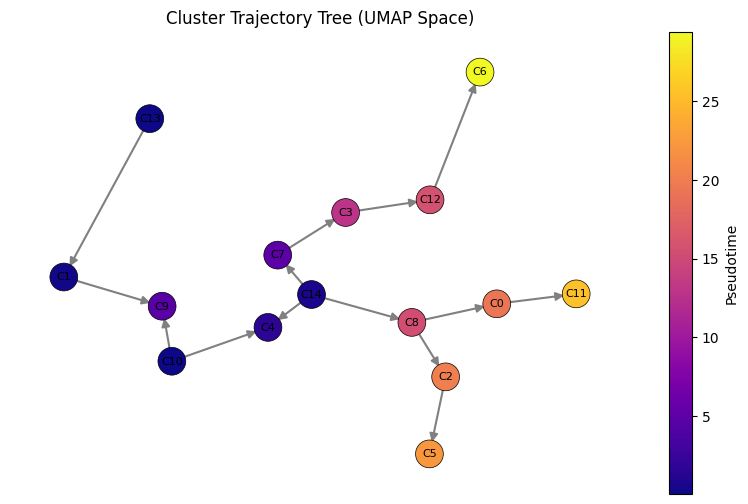

In [13]:
import networkx as nx
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
# Compute cluster-level information
unique_clusters = np.unique(louvain)
centroids = np.array([umap[louvain == cluster].mean(axis=0) for cluster in unique_clusters])
# 1. Build cluster-level MST
dist_mat = distance_matrix(centroids, centroids)
mst_adjacency = minimum_spanning_tree(dist_mat)
mst_csr = mst_adjacency.tocsr()
# 2. Get cluster edges from MST
rows, cols = mst_csr.nonzero()
cluster_edges = [(unique_clusters[i], unique_clusters[j]) for i, j in zip(rows, cols)]
# 3. Compute average pseudotime per cluster
cluster_pseudotime = {cluster: pseudotime[louvain == cluster].mean() 
                     for cluster in unique_clusters}
# Create dictionary of cluster positions
cluster_centroids = {cluster: centroids[i] 
                    for i, cluster in enumerate(unique_clusters)}
# 4. Build and direct the graph
G = nx.Graph()
for cluster in unique_clusters:
    G.add_node(cluster, pos=cluster_centroids[cluster])
G.add_edges_from(cluster_edges)
# Create directed version based on pseudotime
G_directed = nx.DiGraph()
for node in G.nodes(data=True):
    G_directed.add_node(node[0], pos=node[1]['pos'])
for edge in G.edges():
    c1, c2 = edge
    if cluster_pseudotime[c1] < cluster_pseudotime[c2]:
        G_directed.add_edge(c1, c2)
    else:
        G_directed.add_edge(c2, c1)
# 5. Visualize using UMAP coordinates
plt.figure(figsize=(10, 6))
plt.title("Cluster Trajectory Tree (UMAP Space)")
# Get positions and colors
pos = nx.get_node_attributes(G_directed, 'pos')
node_colors = [cluster_pseudotime[node] for node in G_directed.nodes()]
# Draw elements
nx.draw_networkx_nodes(
    G_directed, pos,
    node_size=400,
    node_color=node_colors,
    cmap="plasma",
    edgecolors="black",
    linewidths=0.5
)
nx.draw_networkx_edges(
    G_directed, pos,
    arrowstyle="-|>",
    arrowsize=12,
    edge_color="grey",
    width=1.5
)
nx.draw_networkx_labels(
    G_directed, pos,
    labels={cluster: f"C{cluster}" for cluster in unique_clusters},
    font_size=8
)
# Add colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", 
                          norm=plt.Normalize(vmin=min(node_colors), 
                                           vmax=max(node_colors)))
sm.set_array([])
plt.colorbar(sm, label="Pseudotime", ax=plt.gca())
plt.axis("off")
plt.show()

In [ ]:
import random

def generate_negative_trajectory_report(G_directed, cluster_centroids, cluster_pseudotime, adata):
    """Generate an intentionally flawed natural language trajectory report"""
    all_clusters = list(cluster_pseudotime.keys())

    # Incorrect root cluster: pick a random one (not the real root)
    true_root = min(cluster_pseudotime, key=cluster_pseudotime.get)
    wrong_root = random.choice([c for c in all_clusters if c != true_root])

    # Scrambled pseudotime range
    pseudotime_range = (max(cluster_pseudotime.values()), min(cluster_pseudotime.values()))

    # Scrambled traversal order
    traversal_order = random.sample(all_clusters, len(all_clusters))

    # Fake terminal states: sample random clusters, not necessarily actual leaves
    wrong_leaves = random.sample(all_clusters, min(5, len(all_clusters)))

    # Generate fake edge info: randomly pair clusters and use random distances
    fake_edges = random.sample(
        [(u, v) for u in all_clusters for v in all_clusters if u != v],
        min(len(G_directed.edges()), 10)
    )
    fake_edge_distances = {
        (u, v): np.random.uniform(1.0, 10.0) for (u, v) in fake_edges
    }

    # Get cluster sizes (real)
    cluster_sizes = adata.obs['leiden'].value_counts().to_dict()

    # Construct faulty report
    report = f"""
    Cellular Differentiation Trajectory Analysis Report
    
    * System Overview *
    - Total clusters: {len(all_clusters)}
    - Pseudotime range: {pseudotime_range[0]:.2f} (early) → {pseudotime_range[1]:.2f} (late)
    - Root cluster: {wrong_root} ({cluster_sizes.get(wrong_root, 0)} cells)
    - Terminal states: {', '.join(map(str, wrong_leaves))}
    
    * Trajectory Structure *
    Developmental progression:
    {' → '.join(map(str, traversal_order))}
    
    Key Transitions:
    """ + '\n'.join(
        [f"- {u} → {v} (distance: {fake_edge_distances[(u,v)]:.2f}, cells: {cluster_sizes.get(v, 0)})" 
         for u, v in fake_edges]
    ) + "\n\n"

    return report

# Generate and save the report
trajectory_report = generate_negative_trajectory_report(G_directed, cluster_centroids, cluster_pseudotime, adata)
trajectory_report

In [15]:
import ast
def reconsider_with_monocle(trajectory_tree, context, annotated_clusters, trajectory_report,model_name,model_provider):
    query = f"""
    Perform comprehensive validation of cell trajectory and annotations using biological context and analytical report insights.

    Requirements:
    1. Analyze {context} to identify key gene markers for cell fate determination.
    2. Validate hierarchical structure in {trajectory_tree} matches differentiation pathways.
    3. Resolve any inconsistencies in {annotated_clusters} using markers from {trajectory_report}.
    4. Ensure root node contains all initial progenitor states.
    5. Remove temporal references, focus on lineage relationships.
    6. Finally, make sure that all cell types in the final trajectory structure is in the final cell type annotation dict.

    Current trajectory structure:
    {trajectory_tree}

    Existing cluster annotations:
    {annotated_clusters}

    Output requirements:
    - DO NOT use ```python``` to wrap your python code.
    - Return as a single Python tuple with (trajectory_dict, annotation_dict)
    - Trajectory must be hierarchical dict. set a dummy node as root (use the name "root"), and then add all cell types as leaves.
    - In your output cluster annotations and trajectory structure, all the cell type names should match.

    Only output the Python tuple, no additional text/formatting.

    """
    response = query_llm(content=query, system_role="Bioinformatics expert with single-cell trajectory expertise",model_name=model_name,model_provider=model_provider)
    try:
        return ast.literal_eval(response.strip())
    except (SyntaxError, ValueError) as e:
        print(f"Error parsing LLM response: {e}")
        return trajectory_tree, annotated_clusters

final_trajectory, final_annotation = reconsider_with_monocle(trajectory_tree, context, annotated_clusters, trajectory_report,model_name=model_name,model_provider=model_provider)

print(final_trajectory,final_annotation)

{'root': {'Endodermal progenitors': {'Proliferating endodermal cells': {'Epithelial progenitors': {'Hepatic progenitors': {'Hepatoblasts': {'Mature hepatoblasts': {'Mature hepatocytes': {}}}, 'Proliferating hepatocytes': {}}, 'Primitive streak mesoderm': {}}, 'Cardiomyocytes': {}, 'Endothelial cells': {'Mature endothelial cells': {}}}}, 'Embryonic stem cells': {'Undifferentiated stem cells': {}}}} {'0': 'Cardiomyocytes', '1': 'Endodermal progenitors', '2': 'Endothelial cells', '3': 'Epithelial progenitors', '4': 'Hematopoietic progenitors', '5': 'Hepatic progenitors', '6': 'Hepatoblasts', '7': 'Proliferating endodermal cells', '8': 'Mature hepatocytes', '9': 'Embryonic stem cells', '10': 'Undifferentiated stem cells', '11': 'Mature endothelial cells', '12': 'Mature hepatoblasts', '13': 'Primitive streak mesoderm', '14': 'Proliferating hepatocytes'}


In [16]:
adata.obs['llm_annotated'] = adata.obs['leiden'].map(final_annotation)
adata.obs['llm_annotated'] = adata.obs['llm_annotated'].astype("category")

In [17]:
final_annotation

{'0': 'Cardiomyocytes',
 '1': 'Endodermal progenitors',
 '2': 'Endothelial cells',
 '3': 'Epithelial progenitors',
 '4': 'Hematopoietic progenitors',
 '5': 'Hepatic progenitors',
 '6': 'Hepatoblasts',
 '7': 'Proliferating endodermal cells',
 '8': 'Mature hepatocytes',
 '9': 'Embryonic stem cells',
 '10': 'Undifferentiated stem cells',
 '11': 'Mature endothelial cells',
 '12': 'Mature hepatoblasts',
 '13': 'Primitive streak mesoderm',
 '14': 'Proliferating hepatocytes'}

In [18]:
final_trajectory

{'root': {'Endodermal progenitors': {'Proliferating endodermal cells': {'Epithelial progenitors': {'Hepatic progenitors': {'Hepatoblasts': {'Mature hepatoblasts': {'Mature hepatocytes': {}}},
      'Proliferating hepatocytes': {}},
     'Primitive streak mesoderm': {}},
    'Cardiomyocytes': {},
    'Endothelial cells': {'Mature endothelial cells': {}}}},
  'Embryonic stem cells': {'Undifferentiated stem cells': {}}}}

### output trajectory

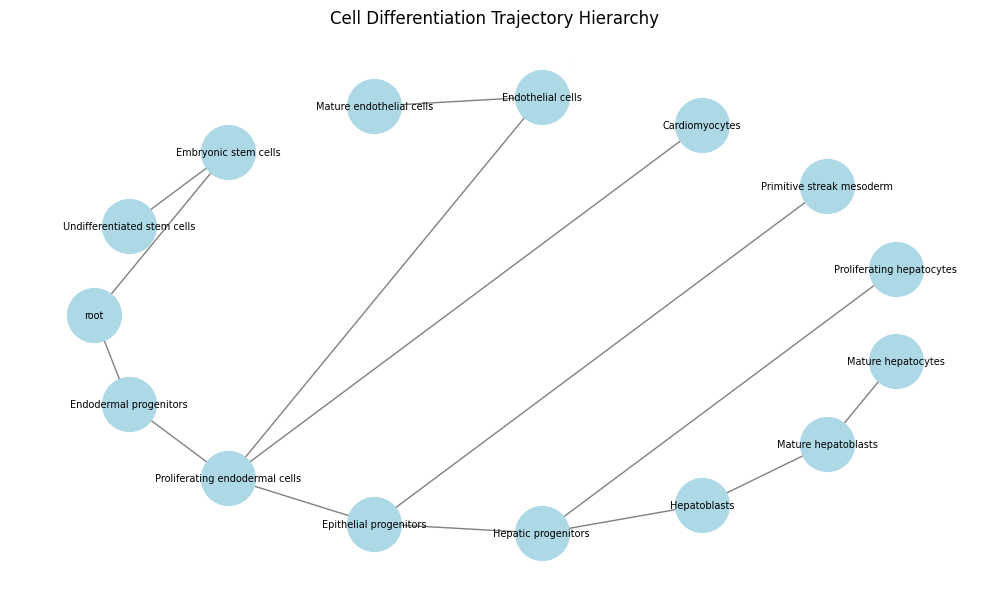

In [19]:
import networkx as nx
import matplotlib.pyplot as plt
def build_trajectory_graph(final_trajectory):
    """Properly constructs graph from nested trajectory dictionary"""
    G = nx.DiGraph()
    G.add_node('root')
    def add_branches(parent, branches):
        for child, subtree in branches.items():
            G.add_edge(parent, child)
            if subtree:
                add_branches(child, subtree)
    add_branches('root', final_trajectory['root'])
    return G
# Create graph from trajectory tree
G = build_trajectory_graph(final_trajectory)
# Create layered layout using multipartite_layout
pos = nx.shell_layout(G)  # More organic spacing
# Fixed visualization code
plt.figure(figsize=(10, 6))
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=7)
# Extract unique y-coordinates for layers
layers = {round(pos[node][1], 2) for node in G.nodes}  # Rounded to handle float precision
# Draw horizontal lines for each layer
ax = plt.gca()
for layer in layers:
    # Find all nodes in this layer
    layer_nodes = [node for node in G.nodes if round(pos[node][1], 2) == layer]
plt.title("Cell Differentiation Trajectory Hierarchy", pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

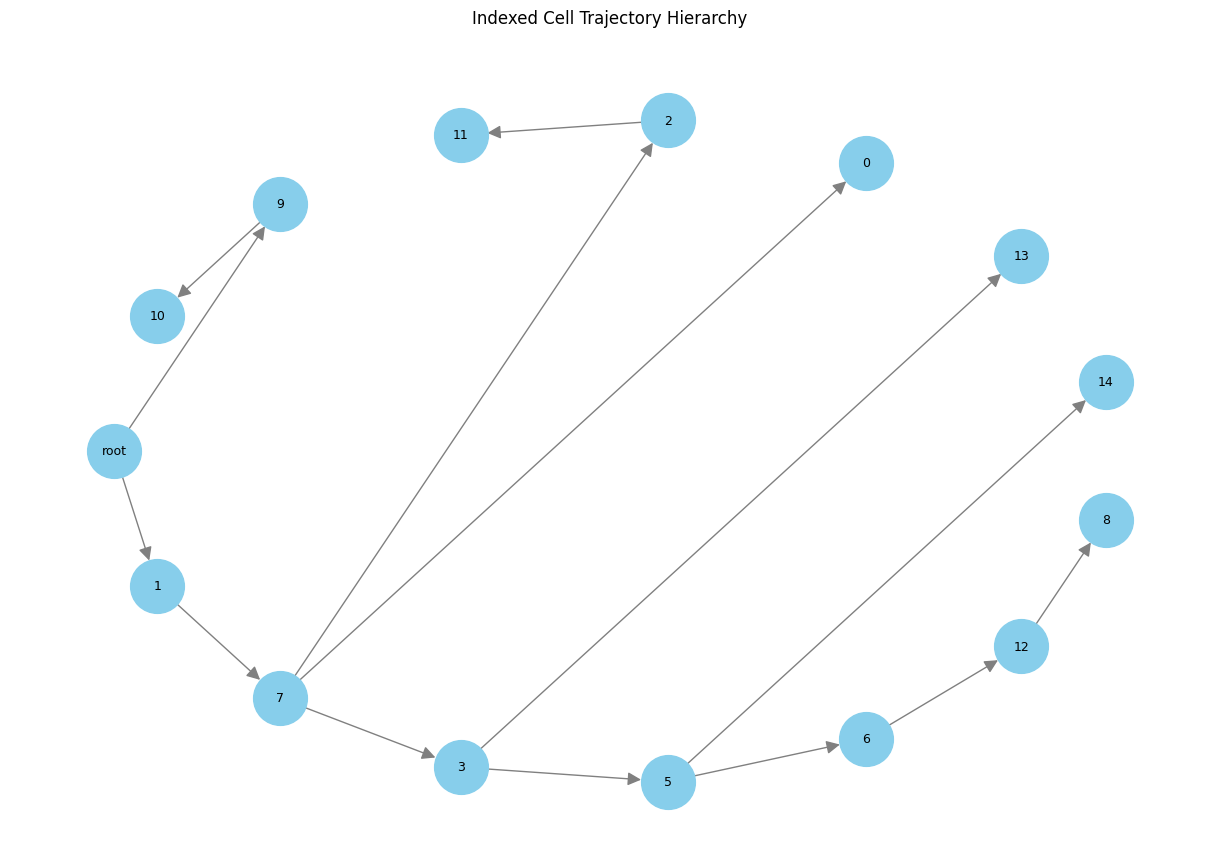

In [20]:
def build_indexed_trajectory(final_trajectory, cell_type_mapping):
    """Convert cell type names to cluster indices in trajectory tree"""
    G = nx.DiGraph()
    name_to_index = {v: k for k, v in cell_type_mapping.items()}
    # Add root node explicitly
    G.add_node('root')
    def add_indexed_branches(parent_name, subtree):
        parent_idx = name_to_index.get(parent_name, parent_name)    
        for child_name, child_subtree in subtree.items():
            child_idx = name_to_index[child_name]       
            # Add edge from parent (could be 'root' or index)
            edge_from = parent_name if parent_name == 'root' else parent_idx
            G.add_edge(edge_from, child_idx)       
            if child_subtree:
                add_indexed_branches(child_name, child_subtree)
    # Start processing from root's children
    add_indexed_branches('root', final_trajectory['root'])
    return G

cell_type_mapping = final_annotation
G = build_indexed_trajectory(final_trajectory, cell_type_mapping)
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G, scale=1.5)
nx.draw(G, pos, 
        with_labels=True,
        node_size=1500,
        node_color='skyblue',
        edge_color='grey',
        font_size=9,
        arrowsize=20)
plt.title("Indexed Cell Trajectory Hierarchy", pad=20)
plt.show()

In [21]:
# Step 1: Map clusters_fig3_final to leiden clusters by majority vote
# Replace adata with your actual AnnData object
import pandas as pd
ct = pd.crosstab(adata.obs["leiden"], adata.obs["Cluster"])
final_annotation = ct.idxmax(axis=1).to_dict()  # {leiden_index: cell_type_name}
cell_type_mapping_truth = {v: int(k) for k, v in final_annotation.items()}  # {cell_type: leiden_index}
cell_type_mapping_truth

{'cardiac mesoderm': 0,
 'definitive endoderm': 1,
 'endothelium': 2,
 'gut tube endoderm': 3,
 'hemangioblast': 4,
 'hematopoietic': 5,
 'hepatoblasts': 6,
 'mesoderm': 7,
 'migrating hepatoblasts': 8,
 'primitive streak I': 9,
 'primitive streak II': 10,
 'septum transversum mesenchyme': 11,
 'splanchnic mesoderm': 12,
 'visceral endoderm': 13,
 'yolk sac': 14}

/var/folders/9w/5ntdw9rd1h11b_tfvc7yq4t80000gn/T/ipykernel_25492/2831566501.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


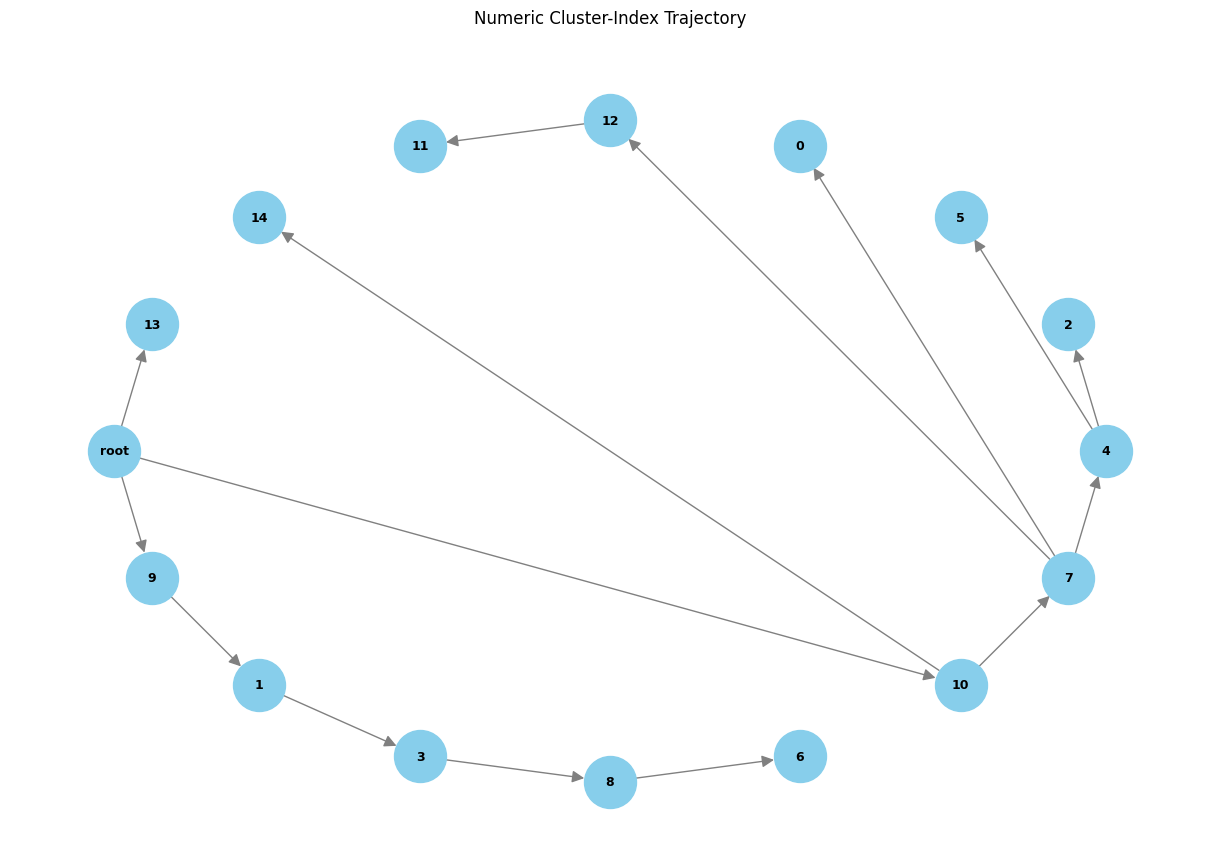

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# ----- final_trajectory is as you defined it -----
traj_ground_truth = { ## manually annnotated 
    "root": {
        9: {
            1: {
                3: {
                    8: {
                    6: {}
                    }
                }
            }
        },
        10: {
            7: {
                4: {
                    2: {},
                    5: {}
                },
                0: {},
                12: {
                    11: {}
                }
            },
            14: {}
        },
        13: {}
    }
}

# ── Build a DiGraph where every node is an index ─────────────
def build_numeric_graph(tree):
    """Convert a nested dict trajectory to a DiGraph (nodes = ints)."""
    G = nx.DiGraph()
    G.add_node("root")
    def _add(parent, subtree):
        for child, grandchild in subtree.items():
            G.add_edge(parent, child)
            if grandchild:                 # recurse on non-leaf children
                _add(child, grandchild)

    _add("root", tree["root"])
    return G

G_ground_truth = build_numeric_graph(traj_ground_truth)

# ── Draw it (indices will be shown directly) ─────────────────
plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G_ground_truth, scale=1.5)          # or nx.spring_layout(G, k=0.7)
nx.draw(
    G_ground_truth, pos,
    with_labels=True,          # prints the numeric indices
    node_size=1400,
    node_color="skyblue",
    edge_color="gray",
    arrows=True,
    arrowsize=18,
    font_size=9,
    font_weight="bold"
)
plt.title("Numeric Cluster-Index Trajectory", pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()

## score

In [23]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# -- 1. Jaccard Similarity of node sets (excluding 'root')
nodes_g = set(G.nodes) 
nodes_directed = set(G_ground_truth.nodes)

nodes_g          = {str(n) for n in nodes_g}
nodes_directed = {str(n) for n in nodes_directed}

intersection = nodes_g & nodes_directed
union = nodes_g | nodes_directed

jaccard_similarity = len(intersection) / len(union)
print(f"Jaccard Similarity (nodes): {jaccard_similarity:.4f}")

Jaccard Similarity (nodes): 0.9375


### the original nx GED function, slow (yet should be most accurate). But consider the actual running time, it cannot output good enough result in reasonable time.

In [24]:
import networkx as nx, time
t0 = time.time()
best = nx.graph_edit_distance(
        G, G_ground_truth,
        timeout=10,           # hard wall-clock stop
        upper_bound=None,    # cheap pruning
        roots=("root","root")           # optional: anchor known roots
)
print(best)
print(f"GED≈{best:.2f}  (computed in {time.time()-t0:.2f}s)")

14.0
GED≈14.00  (computed in 10.00s)


In [25]:
def convert_null_to_empty_dict(data):
    if isinstance(data, dict):
        return {key: convert_null_to_empty_dict(value) for key, value in data.items()}
    elif data is None:
        return {}
    return data

# Save to JSON file
def save_to_json(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

import json
def save_to_json(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

converted_data = convert_null_to_empty_dict(final_trajectory)
save_to_json(converted_data, 'tree1.json')
converted_data = convert_null_to_empty_dict(final_annotation)
save_to_json(converted_data, 'tree1_annotations.json')

### So we used another new GED function based on Cython (much faster)

In [26]:
import ged4py as gm 
ged = gm.GraphEditDistance(1,1,1,1) 
d = ged.compare([G,G_ground_truth],None)[0,1]
d

AttributeError: module 'ged4py' has no attribute 'GraphEditDistance'

In [ ]:
from scipy.linalg import eigvalsh

def get_sorted_laplacian_eigenvalues(graph, k=None):
    # Undirected version for Laplacian
    G_undirected = graph.to_undirected()
    L = nx.normalized_laplacian_matrix(G_undirected).toarray()
    eigenvalues = np.sort(eigvalsh(L))  # compute all eigenvalues
    if k:
        eigenvalues = eigenvalues[:k]  # top-k smallest
    return eigenvalues

# Compute eigenvalues (use top-k to match dimension if graphs are different sizes)
k = min(len(G.nodes), len(G_ground_truth.nodes))  # pick shared dimension
eigvals_g = get_sorted_laplacian_eigenvalues(G, k)
eigvals_directed = get_sorted_laplacian_eigenvalues(G_ground_truth, k)
# Euclidean distance between spectra
spectral_euclidean = np.linalg.norm(eigvals_g - eigvals_directed)
print(f"Spectral Distance (Euclidean, top-{k} eigenvalues): {spectral_euclidean:.4f}")
# Optional: Cosine similarity between spectra
spectral_cosine = cosine_similarity(eigvals_g.reshape(1, -1), eigvals_directed.reshape(1, -1))[0, 0]
print(f"Spectral Cosine Similarity (top-{k} eigenvalues): {spectral_cosine:.4f}")

Spectral Distance (Euclidean, top-16 eigenvalues): 1.2128
Spectral Cosine Similarity (top-16 eigenvalues): 0.9687
